In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import time
import numpy as np

In [2]:
from unicodedata import name


columns = [
           "ID", "Age", "Gender", "Education", "Country", 
           "Ethnicity", "Nscore", "Escore", "Oscore", 
           "Ascore", "Cscore", "Impulsive", "SS", 
           "Alcohol", "Amphet", "Amyl", "Benzos", 
           "Caff", "Cannabis", "Choc", "Coke", 
           "Crack", "Ecstasy", "Heroin", "Ketamine", 
           "Legalh", "LSD", "Meth", "Mushrooms", 
           "Nicotine", "Semer", "VSA"
           ]

data = pd.read_csv("drug_consumption.data", header = None, names=columns)

In [3]:
# checking nan data
data.isna().sum().sum()

0

In [4]:
features = data.iloc[:,1:13]

In [5]:
# Ordinal feature: Age, Education, Nscore, Escore, Oscore, Ascore, Cscore, Impulsive, SS
# Nominal feature: Gender, Country, Ethnicity

# gender is binary so we don't need to encode it here
nominal_f = ['Country', 'Ethnicity']
new_columns = ['USA', 'New Zealand', 'Country_Other', 
               'Australia', 'Ireland', 'Canada', 'UK',
               'Black', 'Asian', 'White', 'Mixed-White/Black',
               'Ethnicity_Other', 'Mixed-White/Asian', 'Mixed-Black/Asian'
              ]

# one hot encode the nominal features
one_hot_features = pd.concat([pd.get_dummies(features[col], prefix=col) for col in nominal_f], axis=1)
# rename the columns after one-hot
one_hot_features = one_hot_features.rename(dict(zip(one_hot_features.columns, new_columns)), axis="columns")
one_hot_features

,USA,New Zealand,Country_Other,Australia,Ireland,Canada,UK,Black,Asian,White,Mixed-White/Black,Ethnicity_Other,Mixed-White/Asian,Mixed-Black/Asian
0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
2,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,0,0,0,0,0,0,1,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1881,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1882,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1883,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [6]:
# use min-max scaler to normilize the ordinal features for

scaler = MinMaxScaler()
ordinal_f = features.drop(nominal_f, axis=1)
norm_ordinal_f = scaler.fit(ordinal_f).transform(ordinal_f)
norm_ordinal_f = pd.DataFrame(norm_ordinal_f, columns=ordinal_f.columns)
norm_ordinal_f

,Age,Gender,Education,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS
0,0.409137,1.0,0.537681,0.560562,0.412116,0.435690,0.367654,0.499040,0.428474,0.224398
1,0.246475,0.0,1.000000,0.413474,0.796106,0.762567,0.609827,0.479394,0.337920,0.465658
2,0.409137,0.0,0.537681,0.444788,0.622976,0.392939,0.266061,0.353580,0.215401,0.619957
3,0.000000,1.0,0.814329,0.492045,0.376883,0.527023,0.585213,0.584415,0.215401,0.224398
4,0.409137,1.0,1.000000,0.623275,0.250544,0.456995,0.456454,0.688508,0.428474,0.465658
...,...,...,...,...,...,...,...,...,...,...
1880,0.000000,1.0,0.412820,0.336890,0.765875,0.835399,0.609827,0.335773,0.629735,1.000000
1881,0.000000,0.0,0.412820,0.477550,0.765875,0.624600,0.609827,0.280854,0.629735,0.710933
1882,0.246475,1.0,0.653938,0.682246,0.289795,0.323599,0.244253,0.300104,0.565343,0.388117
1883,0.000000,1.0,0.412820,0.649318,0.206510,0.577652,0.266061,0.128634,0.705068,0.825752


In [42]:
# concat norminal and ordinal features together
processed_features = pd.concat([norm_ordinal_f, one_hot_features], axis=1)
processed_features

,Age,Gender,Education,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,...,Ireland,Canada,UK,Black,Asian,White,Mixed-White/Black,Ethnicity_Other,Mixed-White/Asian,Mixed-Black/Asian
0,0.409137,1.0,0.537681,0.560562,0.412116,0.435690,0.367654,0.499040,0.428474,0.224398,...,0,0,1,0,0,0,0,0,1,0
1,0.246475,0.0,1.000000,0.413474,0.796106,0.762567,0.609827,0.479394,0.337920,0.465658,...,0,0,1,0,0,1,0,0,0,0
2,0.409137,0.0,0.537681,0.444788,0.622976,0.392939,0.266061,0.353580,0.215401,0.619957,...,0,0,1,0,0,1,0,0,0,0
3,0.000000,1.0,0.814329,0.492045,0.376883,0.527023,0.585213,0.584415,0.215401,0.224398,...,0,0,1,0,0,1,0,0,0,0
4,0.409137,1.0,1.000000,0.623275,0.250544,0.456995,0.456454,0.688508,0.428474,0.465658,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,0.000000,1.0,0.412820,0.336890,0.765875,0.835399,0.609827,0.335773,0.629735,1.000000,...,0,0,0,0,0,1,0,0,0,0
1881,0.000000,0.0,0.412820,0.477550,0.765875,0.624600,0.609827,0.280854,0.629735,0.710933,...,0,0,0,0,0,1,0,0,0,0
1882,0.246475,1.0,0.653938,0.682246,0.289795,0.323599,0.244253,0.300104,0.565343,0.388117,...,0,0,0,0,0,1,0,0,0,0
1883,0.000000,1.0,0.412820,0.649318,0.206510,0.577652,0.266061,0.128634,0.705068,0.825752,...,0,0,0,0,0,1,0,0,0,0


In [8]:
# encode the labels
# 0: CL0 and CL1 (Non user)
# 1: other classes (User)

labels = data.iloc[:,13:]
labels[(labels == 'CL0') | (labels == 'CL1')] = 0
labels[labels != 0] = 1
labels

,Alcohol,Amphet,Amyl,Benzos,Caff,Cannabis,Choc,Coke,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,1,1,1,0,1,1,1,1,0,1,0,1,0,1,1,0,1,0,0
2,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,1,1,1,1,0,0,0,1,0,0,0,0,1,0,0
4,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880,1,0,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,1
1881,1,0,0,0,1,1,1,0,0,1,0,0,1,1,1,1,1,0,0
1882,1,1,1,1,1,1,1,1,0,1,0,1,0,1,0,1,1,0,0
1883,1,0,0,0,1,1,1,0,0,1,0,0,1,1,0,1,1,0,0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.33, random_state=42) # fix the random state for generating same split
print("Training Feature Shape:", X_train.shape)
print("Testing Feature Shape:", X_test.shape)

Training Feature Shape: (1262, 24)
Testing Feature Shape: (623, 24)


### Pipeline for feature selection and classifier and the hyperparameters for random search

In [10]:
# a pipeline and parameters for decision tree
pipe_df = Pipeline([
    ("feature_selection", SelectKBest(chi2)),
    ("Decision_tree", DecisionTreeClassifier(random_state=42))])


param_distributions_df = {
    "feature_selection__k": range(10, 24), # best-k features to select
    "Decision_tree__max_depth": range(20, 100, 2),
    "Decision_tree__min_samples_split": range(2, 10),
}

# a pipeline and parameters for random forest
pipe_rf = Pipeline([
    ("feature_selection", SelectKBest(chi2)),
    ("Random_forest", RandomForestClassifier())])

param_distributions_rf = {
    "feature_selection__k": range(10, 24), # best-k features to select
    "Random_forest__n_estimators": [75, 100, 150],
    "Random_forest__max_depth": range(20, 100, 2),
    "Random_forest__min_samples_split": range(2, 10),
}

# a pipeline and parameters for SVM
pipe_svm = Pipeline([
    ("feature_selection", SelectKBest(chi2)),
    ("SVM", SVC(probability=True))])

param_distributions_svm = {
    "feature_selection__k": range(10, 24), # best-k features to select
    "SVM__C": [1, 0.1, 0.01],
    "SVM__kernel": ["poly", "rbf", "sigmoid"],
    "SVM__degree": range(3, 10) # for poly kernel only
}

# a pipeline and parameters for KNN
pipe_knn = Pipeline([
    ("feature_selection", SelectKBest(chi2)),
    ("KNN", KNeighborsClassifier())])

param_distributions_knn = {
    "feature_selection__k": range(10, 24), # best-k features to select
    "KNN__n_neighbors": range(3, 30),
}

model_names = ["Decision_tree", "Random_forest", "SVM", "KNN"]
model_pipes = [pipe_df, pipe_rf, pipe_svm, pipe_knn]
model_params = [param_distributions_df, param_distributions_rf, param_distributions_svm, param_distributions_knn]

### Training Function

- For each model, use 5-fold random search to draw 60 combinations from the pre-defined hyperparameters
- print out the selected feautures
- Return the best estimator in random search for each model

In [11]:
def train(X_train, y_train):
    best_models = []
    for i, model in enumerate(model_names):
        start = time.time()
        
        print(model + ":")
        # 5-fold CV random search to find the best hyper-parameters
        clf = RandomizedSearchCV(model_pipes[i], model_params[i], n_iter=60, random_state=42, cv=5, scoring="roc_auc")
        search = clf.fit(X_train, y_train)
        print("Best AUC Score for 5-fold:", search.best_score_)
        selected_features = X_train.columns[search.best_estimator_['feature_selection'].get_support()]
        print("Selected features:", list(selected_features))
        best_models.append(search.best_estimator_)
        
        print("Spent time:", time.time()-start)
        print()
    
    return best_models

### Testing Function

- print out the precision and recall score
- Plot confusion matrix for each model's predictions
- Using the prediction probability of the class 1 (User class) from each model to draw the ROC curve on the same plot

In [12]:
def test(X_test, y_test, model_names, models):
    y_pred_probability = []
    f, axes = plt.subplots(1, 4, figsize=(20, 5), sharey='row')
    for i, model in enumerate(model_names):
        print(model + ":")
        y_pred = models[i].predict(X_test)
        y_pred_probability.append(models[i].predict_proba(X_test)[:,1]) # the probability of class 1
        print("Precision:", precision_score(y_test, y_pred))
        print("Recall:", recall_score(y_test, y_pred))

        cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
        ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-User', 'User']).plot(ax=axes[i])
        axes[i].set_title('Confusion matrix of ' + model)
        
        print()
    plt.show()
    
    for i, y_pred in enumerate(y_pred_probability):
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        auc = round(roc_auc_score(y_test, y_pred), 4)
        plt.plot(fpr,tpr,label=model_names[i] + ", AUC="+str(auc))
    
    plt.title('ROC Curve for 4 models')
    plt.legend()
    plt.show()

### Label 1: Legalh

Question 1: can I stack the feature selectors into the a pipeline with the classifier, so for each classifier, it has its own feature selectors

Question 2: Some labels are highly imbalance, do we need to select some imbalance class and some balance classes?

Questiom 3: Some of them are ordinal features, I don't turn them to one-hot encoding but normalize them with min-max scaler

In [13]:
Legalh_label_train, Legalh_label_test = y_train['Legalh'].astype('int'), y_test['Legalh'].astype('int')

In [14]:
print("Number of class 0 in train:", len(Legalh_label_train[Legalh_label_train==0]))
print("Number of class 1 in train:", len(Legalh_label_train[Legalh_label_train==1]))
print("Number of class 0 in test:", len(Legalh_label_test[Legalh_label_test==0]))
print("Number of class 1 in test:", len(Legalh_label_test[Legalh_label_test==1]))

Number of class 0 in train: 773
Number of class 1 in train: 489
Number of class 0 in test: 350
Number of class 1 in test: 273


In [15]:
# training
Legalh_models = train(X_train, Legalh_label_train)

Decision_tree:
Best AUC Score for 5-fold: 0.7602082930270221
Selected features: ['Age', 'Gender', 'Education', 'Oscore', 'Cscore', 'Impulsive', 'SS', 'USA', 'New Zealand', 'Australia', 'Ireland', 'UK', 'Black', 'Asian']
Spent time: 2.7379488945007324

Random_forest:
Best AUC Score for 5-fold: 0.8647407462805887
Selected features: ['Age', 'Gender', 'Education', 'Nscore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'USA', 'New Zealand', 'Country_Other', 'Australia', 'Ireland', 'Canada', 'UK', 'Black', 'Asian', 'White', 'Mixed-White/Black', 'Ethnicity_Other', 'Mixed-White/Asian', 'Mixed-Black/Asian']
Spent time: 50.31685781478882

SVM:
Best AUC Score for 5-fold: 0.8629144717630768
Selected features: ['Age', 'Gender', 'Education', 'Nscore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'USA', 'New Zealand', 'Country_Other', 'Australia', 'Ireland', 'Canada', 'UK', 'Black', 'Asian', 'Ethnicity_Other', 'Mixed-White/Asian']
Spent time: 56.96453595161438

KNN:
Best AUC Score for 5-fold:

Decision_tree:
Precision: 0.7522522522522522
Recall: 0.6117216117216118

Random_forest:
Precision: 0.7747035573122529
Recall: 0.717948717948718

SVM:
Precision: 0.7974137931034483
Recall: 0.6776556776556777

KNN:
Precision: 0.7763157894736842
Recall: 0.6483516483516484



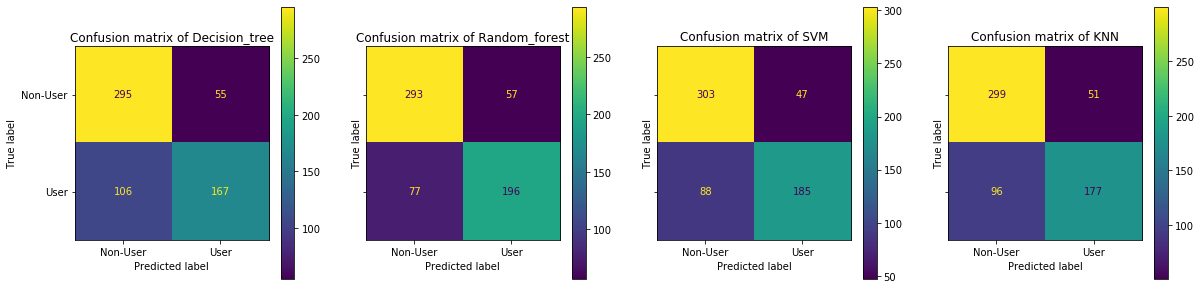

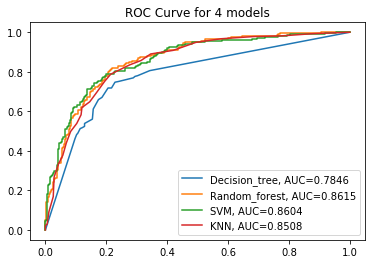

In [16]:
# testing
test(X_test, Legalh_label_test, model_names, Legalh_models)

In [17]:
# Legalh, Ecstasy, Cannabis, Nicotine, Caff, LSD, VSA

### Label 2: Ecstasy

In [18]:
Ecstasy_label_train, Ecstasy_label_test = y_train['Ecstasy'].astype('int'), y_test['Ecstasy'].astype('int')

In [19]:
print("Number of class 0 in train:", len(Ecstasy_label_train[Ecstasy_label_train==0]))
print("Number of class 1 in train:", len(Ecstasy_label_train[Ecstasy_label_train==1]))
print("Number of class 0 in test:", len(Ecstasy_label_test[Ecstasy_label_test==0]))
print("Number of class 1 in test:", len(Ecstasy_label_test[Ecstasy_label_test==1]))

Number of class 0 in train: 763
Number of class 1 in train: 499
Number of class 0 in test: 371
Number of class 1 in test: 252


In [20]:
# training
Ecstasy_models = train(X_train, Ecstasy_label_train)

Decision_tree:
Best AUC Score for 5-fold: 0.7225785130284613
Selected features: ['Age', 'Gender', 'Education', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'USA', 'Country_Other', 'Australia', 'Ireland', 'UK', 'Black', 'Asian', 'Mixed-White/Black', 'Ethnicity_Other', 'Mixed-Black/Asian']
Spent time: 3.1406168937683105

Random_forest:
Best AUC Score for 5-fold: 0.8150711084008299
Selected features: ['Age', 'Gender', 'Education', 'Nscore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'USA', 'Country_Other', 'Australia', 'Ireland', 'UK', 'Black', 'Asian', 'Mixed-White/Black', 'Ethnicity_Other', 'Mixed-Black/Asian']
Spent time: 52.09369111061096

SVM:
Best AUC Score for 5-fold: 0.8160421240266441
Selected features: ['Age', 'Gender', 'Education', 'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'USA', 'Country_Other', 'Australia', 'Ireland', 'UK', 'Black', 'Asian', 'Mixed-White/Black', 'Ethnicity_Other', 'Mixed-White/Asian', 'Mixed-Black/Asian']
Spent time: 57.72

Decision_tree:
Precision: 0.5951417004048583
Recall: 0.5833333333333334

Random_forest:
Precision: 0.6477272727272727
Recall: 0.6785714285714286

SVM:
Precision: 0.6536964980544747
Recall: 0.6666666666666666

KNN:
Precision: 0.6776859504132231
Recall: 0.6507936507936508



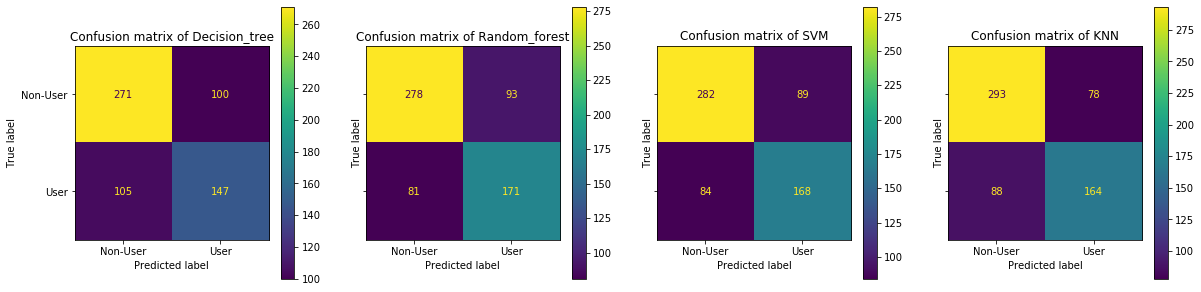

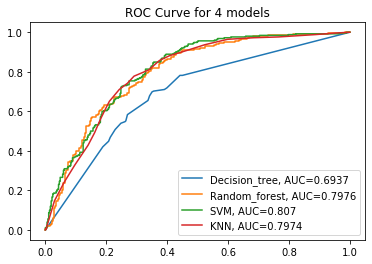

In [21]:
test(X_test, Ecstasy_label_test, model_names, Ecstasy_models)

### Label 3: Cannabis

In [22]:
Cannabis_label_train, Cannabis_label_test = y_train['Cannabis'].astype('int'), y_test['Cannabis'].astype('int')

In [23]:
print("Number of class 0 in train:", len(Cannabis_label_train[Cannabis_label_train==0]))
print("Number of class 1 in train:", len(Cannabis_label_train[Cannabis_label_train==1]))
print("Number of class 0 in test:", len(Cannabis_label_test[Cannabis_label_test==0]))
print("Number of class 1 in test:", len(Cannabis_label_test[Cannabis_label_test==1]))

Number of class 0 in train: 432
Number of class 1 in train: 830
Number of class 0 in test: 188
Number of class 1 in test: 435


In [24]:
# training
Cannabis_models = train(X_train, Cannabis_label_train)

Decision_tree:
Best AUC Score for 5-fold: 0.7860316164417092
Selected features: ['Age', 'Gender', 'Education', 'Oscore', 'Cscore', 'Impulsive', 'SS', 'USA', 'New Zealand', 'Country_Other', 'Australia', 'UK', 'Black', 'Asian', 'Mixed-Black/Asian']
Spent time: 2.880449056625366

Random_forest:
Best AUC Score for 5-fold: 0.877562696656715
Selected features: ['Age', 'Gender', 'Education', 'Nscore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'USA', 'New Zealand', 'Country_Other', 'Australia', 'Ireland', 'Canada', 'UK', 'Black', 'Asian', 'White', 'Ethnicity_Other', 'Mixed-White/Asian', 'Mixed-Black/Asian']
Spent time: 48.903427839279175

SVM:
Best AUC Score for 5-fold: 0.8682772791245172
Selected features: ['Age', 'Gender', 'Education', 'Nscore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'USA', 'New Zealand', 'Country_Other', 'Australia', 'Ireland', 'Canada', 'UK', 'Black', 'Asian', 'White', 'Ethnicity_Other', 'Mixed-Black/Asian']
Spent time: 47.37611222267151

KNN:
Best AUC Sco

Decision_tree:
Precision: 0.8525
Recall: 0.7839080459770115

Random_forest:
Precision: 0.8587443946188341
Recall: 0.8804597701149425

SVM:
Precision: 0.8839907192575406
Recall: 0.8758620689655172

KNN:
Precision: 0.8880778588807786
Recall: 0.8390804597701149



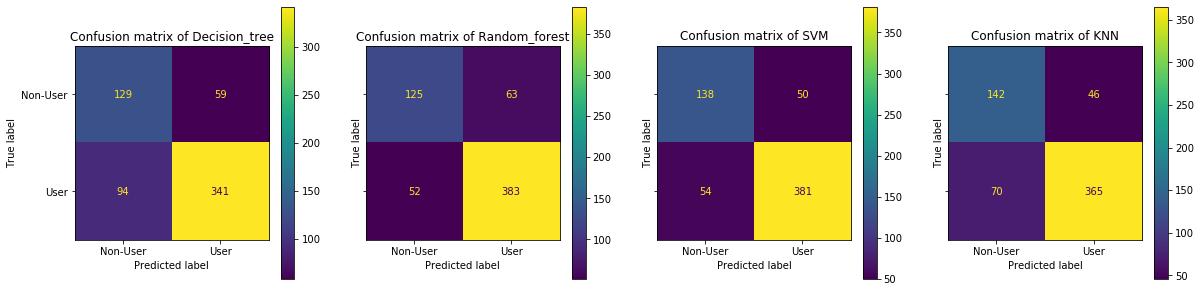

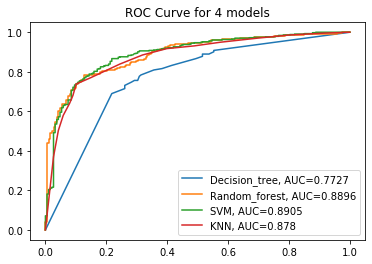

In [25]:
test(X_test, Cannabis_label_test, model_names, Cannabis_models)

### Label 4: Nicotine

In [26]:
Nicotine_label_train, Nicotine_label_test = y_train['Nicotine'].astype('int'), y_test['Nicotine'].astype('int')

In [27]:
print("Number of class 0 in train:", len(Nicotine_label_train[Nicotine_label_train==0]))
print("Number of class 1 in train:", len(Nicotine_label_train[Nicotine_label_train==1]))
print("Number of class 0 in test:", len(Nicotine_label_test[Nicotine_label_test==0]))
print("Number of class 1 in test:", len(Nicotine_label_test[Nicotine_label_test==1]))

Number of class 0 in train: 412
Number of class 1 in train: 850
Number of class 0 in test: 209
Number of class 1 in test: 414


In [28]:
# training
Nicotine_models = train(X_train, Nicotine_label_train)

Decision_tree:
Best AUC Score for 5-fold: 0.6585549082989057
Selected features: ['Age', 'Gender', 'Impulsive', 'SS', 'USA', 'Country_Other', 'Ireland', 'UK', 'Black', 'Asian']
Spent time: 2.682427167892456

Random_forest:
Best AUC Score for 5-fold: 0.7473575219097335
Selected features: ['Age', 'Gender', 'Education', 'Nscore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'USA', 'Country_Other', 'Australia', 'Ireland', 'UK', 'Black', 'Asian', 'Mixed-White/Black', 'Ethnicity_Other', 'Mixed-White/Asian']
Spent time: 48.19208788871765

SVM:
Best AUC Score for 5-fold: 0.7403550500423501
Selected features: ['Age', 'Gender', 'Education', 'Nscore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'USA', 'Country_Other', 'Australia', 'Ireland', 'UK', 'Black', 'Asian', 'Ethnicity_Other', 'Mixed-White/Asian']
Spent time: 54.639586210250854

KNN:
Best AUC Score for 5-fold: 0.7427690100430415
Selected features: ['Age', 'Gender', 'Education', 'Nscore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', '

Decision_tree:
Precision: 0.726790450928382
Recall: 0.6618357487922706

Random_forest:
Precision: 0.7445109780439122
Recall: 0.9009661835748792

SVM:
Precision: 0.6645264847512039
Recall: 1.0

KNN:
Precision: 0.7603485838779956
Recall: 0.8429951690821256



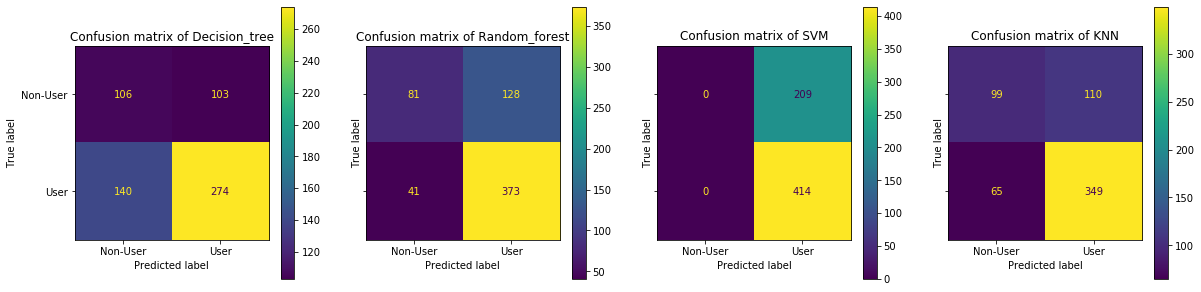

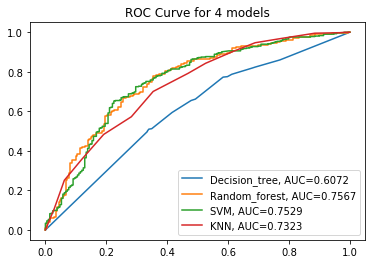

In [29]:
test(X_test, Nicotine_label_test, model_names, Nicotine_models)

### Label 5: Caff

In [30]:
Caff_label_train, Caff_label_test = y_train['Caff'].astype('int'), y_test['Caff'].astype('int')

In [31]:
print("Number of class 0 in train:", len(Caff_label_train[Caff_label_train==0]))
print("Number of class 1 in train:", len(Caff_label_train[Caff_label_train==1]))
print("Number of class 0 in test:", len(Caff_label_test[Caff_label_test==0]))
print("Number of class 1 in test:", len(Caff_label_test[Caff_label_test==1]))

Number of class 0 in train: 26
Number of class 1 in train: 1236
Number of class 0 in test: 11
Number of class 1 in test: 612


In [32]:
# training
Caff_models = train(X_train, Caff_label_train)

Decision_tree:
Best AUC Score for 5-fold: 0.6006108789343084
Selected features: ['Age', 'Gender', 'Escore', 'Oscore', 'Cscore', 'Impulsive', 'SS', 'USA', 'New Zealand', 'Country_Other', 'Australia', 'Ireland', 'Canada', 'UK', 'Black', 'Asian', 'White', 'Mixed-White/Black', 'Ethnicity_Other', 'Mixed-White/Asian', 'Mixed-Black/Asian']
Spent time: 2.3722479343414307

Random_forest:
Best AUC Score for 5-fold: 0.6731239388794567
Selected features: ['Age', 'Gender', 'Escore', 'Oscore', 'Cscore', 'Impulsive', 'SS', 'USA', 'New Zealand', 'Country_Other', 'Ireland', 'Canada', 'UK', 'Black', 'Asian', 'White', 'Mixed-White/Black', 'Mixed-White/Asian', 'Mixed-Black/Asian']
Spent time: 40.18596291542053

SVM:
Best AUC Score for 5-fold: 0.7008997213878368
Selected features: ['Age', 'Gender', 'SS', 'USA', 'Country_Other', 'Canada', 'UK', 'Black', 'Asian', 'White']
Spent time: 10.082680702209473

KNN:
Best AUC Score for 5-fold: 0.6277096121196291
Selected features: ['Age', 'Gender', 'Escore', 'Oscore'

Decision_tree:
Precision: 0.9818181818181818
Recall: 0.9705882352941176

Random_forest:
Precision: 0.9823434991974318
Recall: 1.0

SVM:
Precision: 0.9822866344605475
Recall: 0.9967320261437909

KNN:
Precision: 0.9823434991974318
Recall: 1.0



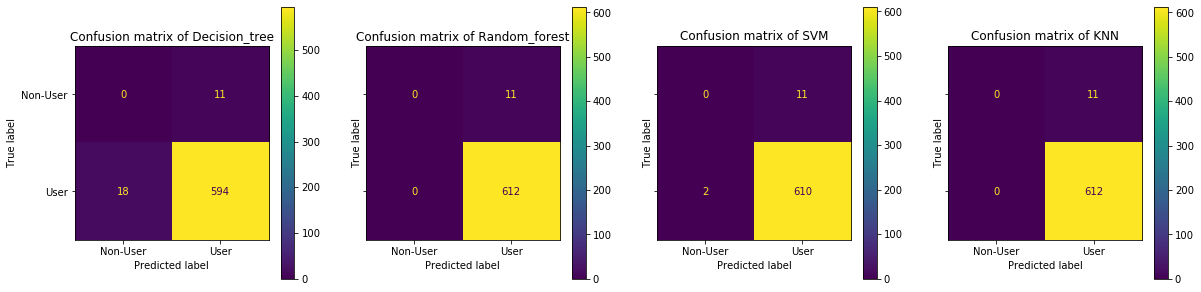

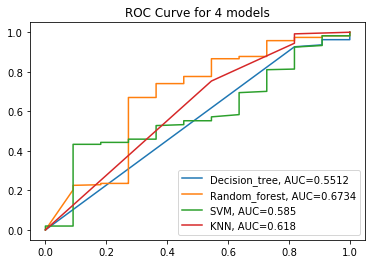

In [33]:
test(X_test, Caff_label_test, model_names, Caff_models)

### Label 6: LSD

In [34]:
LSD_label_train, LSD_label_test = y_train['LSD'].astype('int'), y_test['LSD'].astype('int')

In [35]:
print("Number of class 0 in train:", len(LSD_label_train[LSD_label_train==0]))
print("Number of class 1 in train:", len(LSD_label_train[LSD_label_train==1]))
print("Number of class 0 in test:", len(LSD_label_test[LSD_label_test==0]))
print("Number of class 1 in test:", len(LSD_label_test[LSD_label_test==1]))

Number of class 0 in train: 895
Number of class 1 in train: 367
Number of class 0 in test: 433
Number of class 1 in test: 190


In [36]:
# training
LSD_models = train(X_train, LSD_label_train)

Decision_tree:
Best AUC Score for 5-fold: 0.7649590778503307
Selected features: ['Age', 'Gender', 'Oscore', 'Impulsive', 'SS', 'USA', 'New Zealand', 'Country_Other', 'Australia', 'UK', 'Black', 'Ethnicity_Other']
Spent time: 2.5333900451660156

Random_forest:
Best AUC Score for 5-fold: 0.8668036253901411
Selected features: ['Age', 'Gender', 'Education', 'Nscore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'USA', 'New Zealand', 'Country_Other', 'Australia', 'UK', 'Black', 'Asian', 'Ethnicity_Other', 'Mixed-White/Asian', 'Mixed-Black/Asian']
Spent time: 45.99701762199402

SVM:
Best AUC Score for 5-fold: 0.8590055617720729
Selected features: ['Age', 'Gender', 'Oscore', 'Impulsive', 'SS', 'USA', 'New Zealand', 'Country_Other', 'Australia', 'UK', 'Black', 'Ethnicity_Other']
Spent time: 46.42641997337341

KNN:
Best AUC Score for 5-fold: 0.8717872958287745
Selected features: ['Age', 'Gender', 'Oscore', 'Impulsive', 'SS', 'USA', 'New Zealand', 'Country_Other', 'Australia', 'UK', 'Black',

Decision_tree:
Precision: 0.5513513513513514
Recall: 0.5368421052631579

Random_forest:
Precision: 0.5935828877005348
Recall: 0.5842105263157895

SVM:
Precision: 0.6062176165803109
Recall: 0.6157894736842106

KNN:
Precision: 0.6097560975609756
Recall: 0.6578947368421053



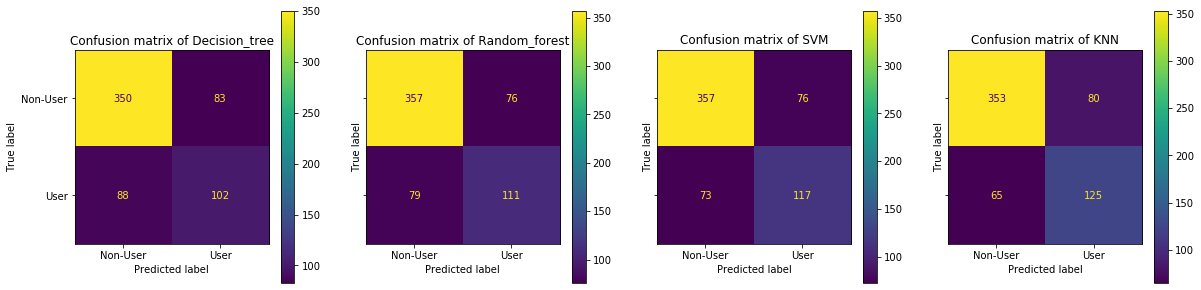

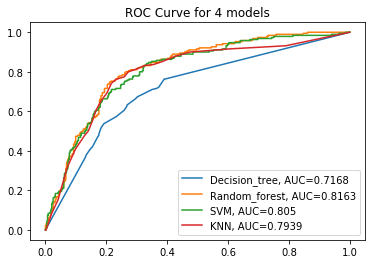

In [37]:
test(X_test, LSD_label_test, model_names, LSD_models)

### Label 7: VSA

In [38]:
VSA_label_train, VSA_label_test = y_train['VSA'].astype('int'), y_test['VSA'].astype('int')

In [39]:
print("Number of class 0 in train:", len(VSA_label_train[VSA_label_train==0]))
print("Number of class 1 in train:", len(VSA_label_train[VSA_label_train==1]))
print("Number of class 0 in test:", len(VSA_label_test[VSA_label_test==0]))
print("Number of class 1 in test:", len(VSA_label_test[VSA_label_test==1]))

Number of class 0 in train: 1113
Number of class 1 in train: 149
Number of class 0 in test: 542
Number of class 1 in test: 81


In [40]:
# training
VSA_models = train(X_train, VSA_label_train)

Decision_tree:
Best AUC Score for 5-fold: 0.690702123183954
Selected features: ['Age', 'Gender', 'Education', 'Cscore', 'Impulsive', 'SS', 'USA', 'Australia', 'Ireland', 'UK', 'Black', 'Ethnicity_Other']
Spent time: 2.5311381816864014

Random_forest:
Best AUC Score for 5-fold: 0.8231073976404113
Selected features: ['Age', 'Gender', 'Education', 'Oscore', 'Cscore', 'Impulsive', 'SS', 'USA', 'Australia', 'Ireland', 'UK', 'Black', 'Mixed-White/Black', 'Ethnicity_Other']
Spent time: 44.121253967285156

SVM:
Best AUC Score for 5-fold: 0.7478236331274835
Selected features: ['Age', 'Gender', 'Education', 'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'USA', 'New Zealand', 'Country_Other', 'Australia', 'Ireland', 'Canada', 'UK', 'Black', 'White', 'Mixed-White/Black', 'Ethnicity_Other', 'Mixed-White/Asian', 'Mixed-Black/Asian']
Spent time: 29.96605086326599

KNN:
Best AUC Score for 5-fold: 0.8022666566365345
Selected features: ['Age', 'Gender', 'Education', 'Nscore', 'Osco

Decision_tree:
Precision: 0.36486486486486486
Recall: 0.3333333333333333

Random_forest:
Precision: 0.2727272727272727
Recall: 0.037037037037037035

SVM:
Precision: 0.3333333333333333
Recall: 0.1728395061728395

KNN:
Precision: 0.0
Recall: 0.0



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


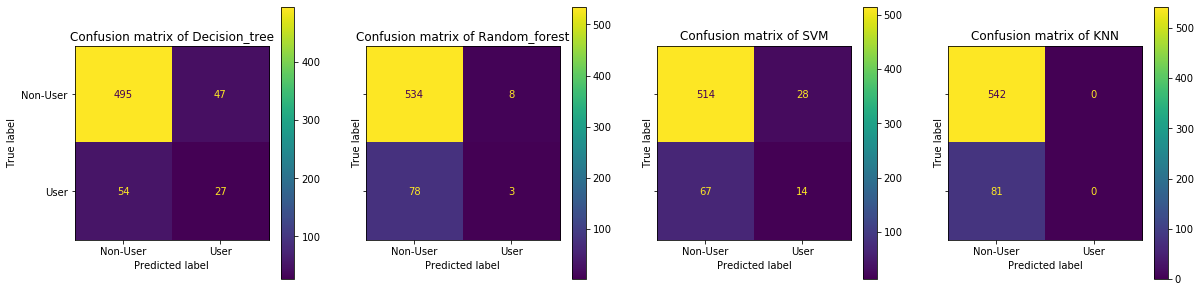

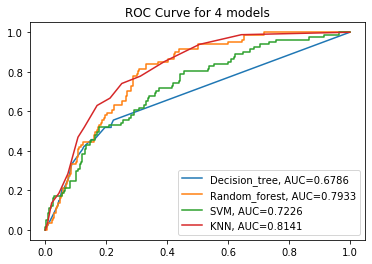

In [41]:
test(X_test, VSA_label_test, model_names, VSA_models)